In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [ ]:
offers = pd.read_csv('offers.csv.gz', compression='gzip')
print(offers.shape)
offers.head()


In [4]:
offers.nunique()

offer         37
category      20
quantity       2
company       18
offervalue     7
brand         19
dtype: int64

In [ ]:
#Checking how the data looks in this table.
fig, axes = plt.subplots(2,2, figsize=(15,6))
offers.groupby('company')['offer'].count().sort_values().plot(kind='bar', title='Company vs. No. of Offers', grid=True, ax=axes[0,0])
offers.groupby('brand')['offer'].count().sort_values().plot(kind='bar', title='Brand vs. No. of Offers', grid=True, ax=axes[0,1])
offers.groupby('category')['offer'].count().sort_values().plot(kind='bar', title='Category vs. No. of Offers', grid=True, ax=axes[1,0])
offers.groupby('offer')['offervalue'].sum().sort_values().plot(kind='bar', title='Offer vs. Offer Value', grid=True, ax=axes[1,1])
plt.tight_layout()

<AxesSubplot:title={'center':'Product vs. No. of Offers'}, xlabel='company,brand,category'>

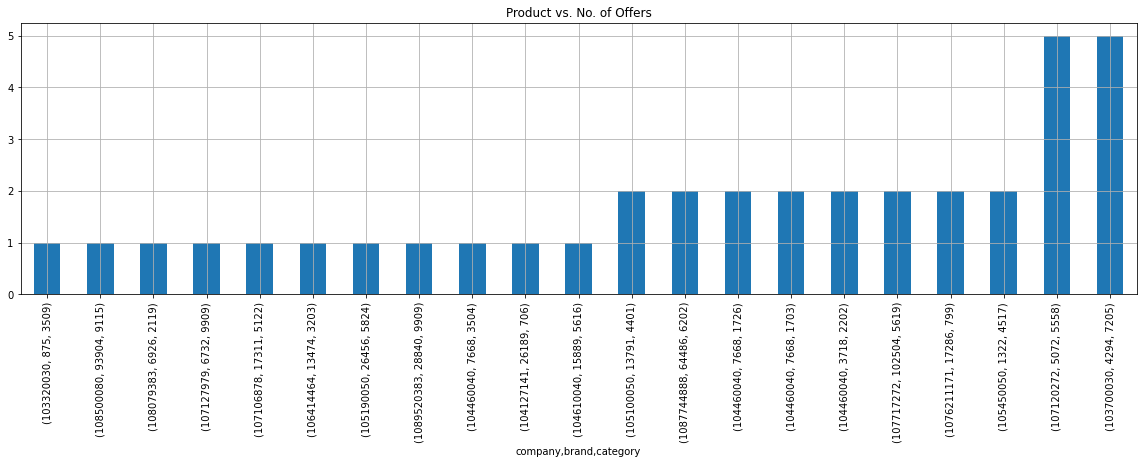

In [6]:
# since a combination of company, brand and category uniquely identifies a product, 
# I want to see if product has many offers or just one.
offers.groupby(['company','brand','category'])['offer'].size().sort_values().plot(kind='bar', title='Product vs. No. of Offers', grid=True, figsize=(20,5))

In [ ]:
#Checking how many offers need a minimum quantity of more than 2
print(offers.quantity.value_counts())

In [8]:
#this table shows that there are 10 products which have duplicate offers. I mean that the minimum purchase quantity
#required and. offer value is same for duplicate offers. THEY MAY BE COMBINED TOGETHER.
offers.groupby(['company','brand','category'])['offer','quantity','offervalue'].nunique()

<ipython-input-8-e9491df26ced>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  offers.groupby(['company','brand','category'])['offer','quantity','offervalue'].nunique()


offer  quantity  offervalue
company    brand  category                             
103320030  875    3509          1         1           1
103700030  4294   7205          5         2           3
104127141  26189  706           1         1           1
104460040  3718   2202          2         1           2
           7668   1703          2         1           1
                  1726          2         1           1
                  3504          1         1           1
104610040  15889  5616          1         1           1
105100050  13791  4401          2         1           1
105190050  26456  5824          1         1           1
105450050  1322   4517          2         1           1
106414464  13474  3203          1         1           1
107106878  17311  5122          1         1           1
107120272  5072   5558          5         1           1
107127979  6732   9909          1         1           1
107717272  102504 5619          2         1           1
108079383  6926   2119          1         1           1
108500080  93904  9115          1         1           1
1076211171 17286  799           2         1           1
1087744888 64486  6202          2         1           1
1089520383 28840  9909          1         1           1

In [ ]:
#reading customer history data when the offer was given to them
trainHistory = pd.read_csv('trainHistory.csv.gz', compression='gzip')
trainHistory['offerdate'] = pd.to_datetime(trainHistory['offerdate'])
print(trainHistory.shape)
trainHistory.sort_values(by='repeattrips', ascending=False).head(1)

In [ ]:
print('Ending date: ',trainHistory.offerdate.max())
print('Starting date: ',trainHistory.offerdate.min())
print('Offers were given in ', trainHistory.offerdate.max() - trainHistory.offerdate.min(), ' period')
#So the offers were given in a 60 days period from March 1 2013 to April 30 2013

In [ ]:
#there are no null values in the dataset
trainHistory.isnull().sum()

In [ ]:
#This shows that out of 37 offers in the offer table, there are 24 offers in trainHistory table.
trainHistory.nunique()

In [ ]:
#Now I wanna check how many trips were made by each customer first. 
#This shows that the max trips are 2124 by a customer. That seem to be an outlier.
trainHistory.repeattrips.describe()

In [ ]:
trainHistory[trainHistory.repeattrips > 100]
#This shows that there are 3 potential outliers for number of trips

In [ ]:
#Let's see of the given customers, how may are repeaters
#Let's see how many customers are offered a particular offer
#How many chains are in each market
#How many customers repeated after given a particular offer
fig, axes = plt.subplots(2,2, figsize=(15,10))
trainHistory.groupby('offer')['id'].count().plot(kind='bar', title='Offers vs. Customer Count', grid=True, ax=axes[0,0])
trainHistory.repeater.value_counts().plot(kind='pie', title='% Repeat Customers', ax=axes[0,1], autopct='%1.1f%%', textprops=dict(color="black"))
trainHistory.groupby('market')['chain'].count().sort_values().plot(kind='bar', title='Chain Count in each Market', grid=True, ax=axes[1,0])
trainHistory.groupby(['offer','repeater']).size().unstack().plot(kind='bar', title='Offer vs. Repeaters', grid=True, ax=axes[1,1], stacked=True)
plt.tight_layout()

In [ ]:
#merging trainHistory and Offers table to see how many customer repeated for a particular product (company, brand, category)
history = trainHistory.merge(offers, on='offer')
print(history.shape)
history.head(1)

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
history.groupby(['company','repeater']).size().unstack().plot(kind='bar', title='Company vs. Repeaters', grid=True, stacked=True, ax=axes[0,0])
history.groupby(['brand','repeater']).size().unstack().plot(kind='bar', title='Brand vs. Repeaters', grid=True, stacked=True, ax=axes[0,1])
history.groupby(['category','repeater']).size().unstack().plot(kind='bar', title='Category vs. Repeaters', grid=True, stacked=True, ax=axes[1,0])
history.groupby(['company','brand','category','repeater']).size().unstack().plot(kind='bar', title='Product vs. Repeaters', grid=True, stacked=True, ax=axes[1,1])
plt.tight_layout()
#Companies ending with 7979, 9383, 0383 have higher % of repeat customers than others
#Brand 6732, 6926, 28840 have the higher % repeat customers than others
#Catogories 2119, 9909 have higher % of repeat customers than other
#When I combine all of them together to see exactly which product is getting higher repeat customers than average
#(7979,6732,9909), (9383,6926,2119) comes out to be the best ones. This shows is the same pattern as we saw
#individually in Company, Brand and Category 

In [ ]:
fig, ax =plt.subplots(1, figsize=(20,5))
sns.boxplot(x = history.offer, y = history.repeattrips, palette="Set3")
plt.tight_layout()
#The 3 outliers are the same that we saw above. 
#So it would make sense to remove them from this plot and see how it looks

In [ ]:
subset = history[history.repeater == 't']
fig, ax =plt.subplots(1, figsize=(20,5))
sns.boxplot(x = subset.offer, y = subset.repeattrips)
plt.ylim(-1, 15)
plt.tight_layout()
#This shows that out of those who are repeaters, Offer 044,052,329,501  have median value = 2, rest all have 1.


In [ ]:
#Reading testHistory dataset where I have to predict if a person is going to be a repeat customer or not
testHistory = pd.read_csv('testHistory.csv.gz', compression='gzip')
testHistory.offerdate = pd.to_datetime(testHistory.offerdate)
print(testHistory.shape)
testHistory.head(3)

In [ ]:
#I should now see how much overlap is there in id, chain, market and offer to see how much variation is there
#Check if there are any common customers in train and test data
columns = ['id','chain','market','offer']
for c in columns:
    train = trainHistory[c]
    test = testHistory[c]
    print('Common', c, len(set(train).intersection(set(test))))

In [ ]:
print('Ending date: ',testHistory.offerdate.max())
print('Starting date: ',testHistory.offerdate.min())
print('Offers were given in ', testHistory.offerdate.max() - testHistory.offerdate.min(), ' period')
#So the offers were given in a 91 days period from May 1 2013 to July 31 2013

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,5))
trainHistory.groupby('offer')['id'].count().sort_values().plot(kind='bar', title='Training [Offers vs. Customer Count]', grid=True, ax=axes[0,0])
testHistory.groupby('offer')['id'].count().sort_values().plot(kind='bar', title='Test [Offers vs. Customer Count]', grid=True, ax=axes[0,1])
trainHistory.groupby('market')['chain'].count().sort_values().plot(kind='bar', title='Training [Chain Count in each Market]', grid=True, ax=axes[1,0])
testHistory.groupby('market')['chain'].count().sort_values().plot(kind='bar', title='Test [Chain Count in each Market]', grid=True, ax=axes[1,1])
plt.tight_layout()
# #Not much correlation between training & test dataset in terms of offers and markets

In [ ]:
#Since the dataset is too large, I am interested to learn about only those products that are on offer based on the
#offer table

#To be able to do that, I need to find all products on offer in both training and test datasets.
#Merging testHistory table with offers
pred_history = testHistory.merge(offers, on='offer')
pred_history.head()

In [ ]:
comp_tmp = history.company
comp_tmp1 = pred_history.company
comp_tmp = comp_tmp.append(comp_tmp1)
comp_tmp = comp_tmp.unique()
comp_tmp = set(comp_tmp)

brand_tmp = history.brand
brand_tmp1 = pred_history.brand
brand_tmp = brand_tmp.append(brand_tmp1)
brand_tmp = brand_tmp.unique()
brand_tmp = set(brand_tmp)

cat_tmp = history.category
cat_tmp1 = pred_history.category
cat_tmp = cat_tmp.append(cat_tmp1)
cat_tmp = cat_tmp.unique()
cat_tmp = set(cat_tmp)

In [ ]:
#Creating DUMMY VARIABLES for market, offer, chain, company, brand, category
dummies = ['market', 'offer', 'chain', 'company', 'brand', 'category']
for d in dummies:
    #adding dummies to train data
    dummy = pd.get_dummies(history[d], prefix=d, prefix_sep='_', drop_first=True)
    history = history.merge(dummy, left_index=True, right_index=True)
    #adding dummies to test data
    dummy = pd.get_dummies(pred_history[d], prefix=d, prefix_sep='_', drop_first=True)
    pred_history = pred_history.merge(dummy, left_index=True, right_index=True)

pred_history_id = pd.DataFrame(pred_history.id)

#deleting columns that are not required in training & test dataset
columns = ['id','chain','offer','market','prod_id','offerdate','quantity','category','brand','company']
for x in columns:
    if x in history.columns:
        history = history.drop([x], axis = 1)
    if x in pred_history.columns:
        pred_history = pred_history.drop([x], axis = 1)
print('fghjkl;')


In [ ]:
#Now adding those columns to trainHistory & pred_history table which are not common to both
common_cols = set(history.columns) & set(pred_history)
print('Common column length: ', len(common_cols))
print('trainHistory column length: ', len(history.columns))
print('testHistory column length: ', len(pred_history.columns))
to_add_in_train = set(pred_history.columns) - common_cols
print('Columns to be added in trainHistory: ', to_add_in_train)
print('Columns to be added in trainHistory: ', len(to_add_in_train))
to_add_in_test = set(history.columns) - common_cols
print('Columns to be added in testHistory: ', to_add_in_test)
print('Columns to be added in testHistory: ', len(to_add_in_test))